# Exploring Inland Water Bodies with Sentinel-2 data in EDC

In [1]:
from edc import check_compatibility
check_compatibility("user-2023.03-02", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


---
author: Anca Anghelea, based on a [notebook by: _William Ray_](https://eurodatacube.com/notebooks/curated/Exploring_time_and_space_with_EDC.ipynb)

Several lakes and other inland water bodies are featured on EO Dashboard. The datasets supporting the various geo-stories are accessible by means similar to what you will learn in this notebook.

[Explore EO Dashboard Stories on Oceans and Inland Water](https://eodashboard.org/oceans). 

## In this notebook

In this demonstration Jupyter Notebook, we will be visualising and analysing inland water bodies using Sentinel data, demonstrating the use of EDC. 


We are going to use the EDC and its associated libaries and APIs to do this. In this notebook we will learn how to:

- Build a cube
- Visualise a variable in your data cube
- Create a new variable
- Create a new variable using a threshold
- Visualise a spatial subset of a variable over time
- Create a new variable based upon space and time. 

## Configuration

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace), and generate credentials automatically to access the services.

In [2]:
# EDC libraries
from edc import setup_environment_variables
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
from xcube.core.gen2.local.combiner import CubesCombiner
from xcube.core.geom import mask_dataset_by_geometry

# Sentinel Hub
from sentinelhub import BBox, SentinelHubRequest, bbox_to_dimensions, DataCollection, MimeType, SHConfig, geometry

# Utilities
import IPython.display
from os import environ
import matplotlib.pyplot as plt
import datetime as dt
import geopandas
import rioxarray

# Numerical computation
import xarray as xr
import numpy as np

# Fetch credentials as environement variables
setup_environment_variables()

# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=environ["SH_CLIENT_ID"],
                      client_secret=environ["SH_CLIENT_SECRET"])

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:



***Define an AOI***

Next, we will define our area of interest using a bounding box. This must be provided in WGS84 coordinates to build the cube.

We have chosen an AOI covering the natural park "Valli di Comacchio" in Italy.

In [3]:
# Define the coordinates of the bounding box
lake_bbox = [12.09, 44.54, 12.27, 44.70]

# Bbox EPSG
bbox_epsg = 4326


In [4]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(lake_bbox,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### How to build a data cube

Firstly, we will go through how to build a data cube.

We are going to visualise the floods using Sentinel-2 imagery. Sentinel-2 is part of the Copernicus programme and collects multispectral data globally with a revisit time of 5 days. The satellite's multispectral imager provides collects data in 13 spectral bands spanning from the visible and near infrared to the shortwave infrared. The visible and near infrared data we will use in this example is collected at 10m resolution. 

***Check Sentinel-2 L2A available bands***

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset to help us build the cube! 

In [5]:
# Create a Sentinel Hub class, using our Sentinel Hub credentials
SH = SentinelHub(**sh_credentials)

# List bands for S2-L2A
SH.band_names('S2L2A')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'SCL',
 'SNW',
 'CLD',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'AOT',
 'CLM',
 'CLP']

***Build an xcube***

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L2A` for Sentinel-2 L2A. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the B02, B03, B04, B08, CLM (Blue, Green, Red, NIR, Cloud Mask) bands.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L2A data is available from October 2016 onwards. In this example, we will fetch data for June 2023 - mid July 2023.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30m` corresponds to 30 minutes, thus avoiding duplicate datasets.

In [6]:
# Setup xcube
s2_cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B02', 'B03', 'B04', 'B08', 'CLM'],
                         bbox=lake_bbox,
                         spatial_res=0.000089,
                         time_range=['2023-06-01', '2023-07-16'],
                         time_tolerance='30m')

***Open the xcube***

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube. It's important to note that at this stage, we're not processing anything, just generating a cube on the fly with data ready to be called when needed for analysis.

Once you open the cube, you can visualise the contents. You can view the number of timestamps and a list of them all too in the Coordinates tab. You can also visualise the seperate variables, with information on the size of the variables and their data type too.  

In [7]:
# Open cube (on the fly)
s2_cube = open_cube(s2_cube_config, **sh_credentials)

# Display contents
s2_cube

/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/xcube_sh/sentinelhub.py:243: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(dt,
/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/xcube_sh/sentinelhub.py:243: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(dt,


<xarray.Dataset>
Dimensions:    (time: 18, lat: 1886, lon: 2122, bnds: 2)
Coordinates:
  * lat        (lat) float64 44.71 44.71 44.71 44.71 ... 44.54 44.54 44.54 44.54
  * lon        (lon) float64 12.09 12.09 12.09 12.09 ... 12.28 12.28 12.28 12.28
  * time       (time) datetime64[ns] 2023-06-02T10:18:28 ... 2023-07-14T10:08:32
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(18, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-07-16T01:24:44.851881
    time_coverage_start:     2023-06-02T10:18:28+00:00
    time_coverage_end:       2023-07-14T10:08:32+00:00
    time_coverage_duration:  P41DT23H50M4S
    geospatial_lon_min:      12.09
    geospatial_lat_min:      44.54
    geospatial_lon_max:      12.278858
    geospatial_lat_max:      44.707854
    processing_level:        L2A

### How to visualise your datacube

Now we have built our cube, let's visualise the data! We are going to visualise a True Color image and an NDWI image in the same plot. In the below cell you can see we are selecting each band for 10:00:00 16th June 2023, and selecting the nearest acquisition to this date and time. We then stack the three bands and plot this using Matplotlib. We will call the three bands in the visible spectrum. In addition we will multiply the reflectance values by 5 to brighten the image.

Another way to visualise the extent of surface water is to use the Normalised Difference Water Index (NDWI). This is an index that can be used to extract surface water using multispectral imagery such as Sentinel-2. We can calculate the index with the Green and NIR bands as stated below, and add it into the data cube as a new variable.

NDWI = Green - NIR / Green + NIR

For this we are going to create a new variable in the next cell. To create the new variable we are using two existing variables defined as s2_cube.B03 and s2_cube.B08. We then insert these variables into an index formula to create NDWI. Once ndwi has been calculated it's attributed a long_name and units before being defined as ndwi so that we can call it as a definition later in the notebook.

In [8]:
# Define NDWI in visualisation
ndwi = ((s2_cube.B03-s2_cube.B08)/(s2_cube.B03+s2_cube.B08))

ndwi.attrs['long_name']='NDWI'
ndwi.attrs['units']='unitless'

s2_cube['NDWI']= ndwi  

Next we want to plot both the True Color image and the NDWI in the same plot. We will use Matplotlib to achieve this. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


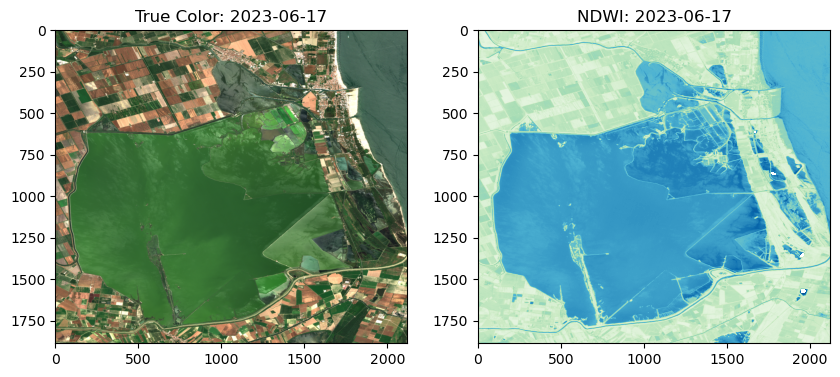

In [9]:
# Select the bands and stack them.
Red = s2_cube.B04.sel(time='2023-06-17 10:00:00', method='nearest')
Green = s2_cube.B03.sel(time='2023-06-17 10:00:00', method='nearest')
Blue = s2_cube.B02.sel(time='2023-06-17 10:00:00', method='nearest')

rgb = np.dstack((Red,Green,Blue)) #Stack the three arrays

ndwi = s2_cube.NDWI.sel(time='2023-06-17 10:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[10, 15])
f.add_subplot(1, 2, 1)
plt.title(f"True Color: {str(s2_cube.time.sel(time='2023-06-17 10:00:00', method='nearest').data).split('T')[0]}")
plt.imshow(5 * rgb)  # We multiply the rgb by 5 to make the image brighter
f.add_subplot(1, 2, 2)
plt.title(f"NDWI: {str(s2_cube.time.sel(time='2023-06-17 10:00:00', method='nearest').data).split('T')[0]}")
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='GnBu')
plt.show()

This looks good, and the extent of the flood waters is visualised really nicely here. The 10m resolution also enables us to see individual fields around the lake with the linear boundaries of the fields highlighted nicely in the high resolution image provided by the 10m Sentinel 2 bands. 

Let's try and visualise some more dates in the time period that we are examining; 

/tmp/ipykernel_490/1879529373.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


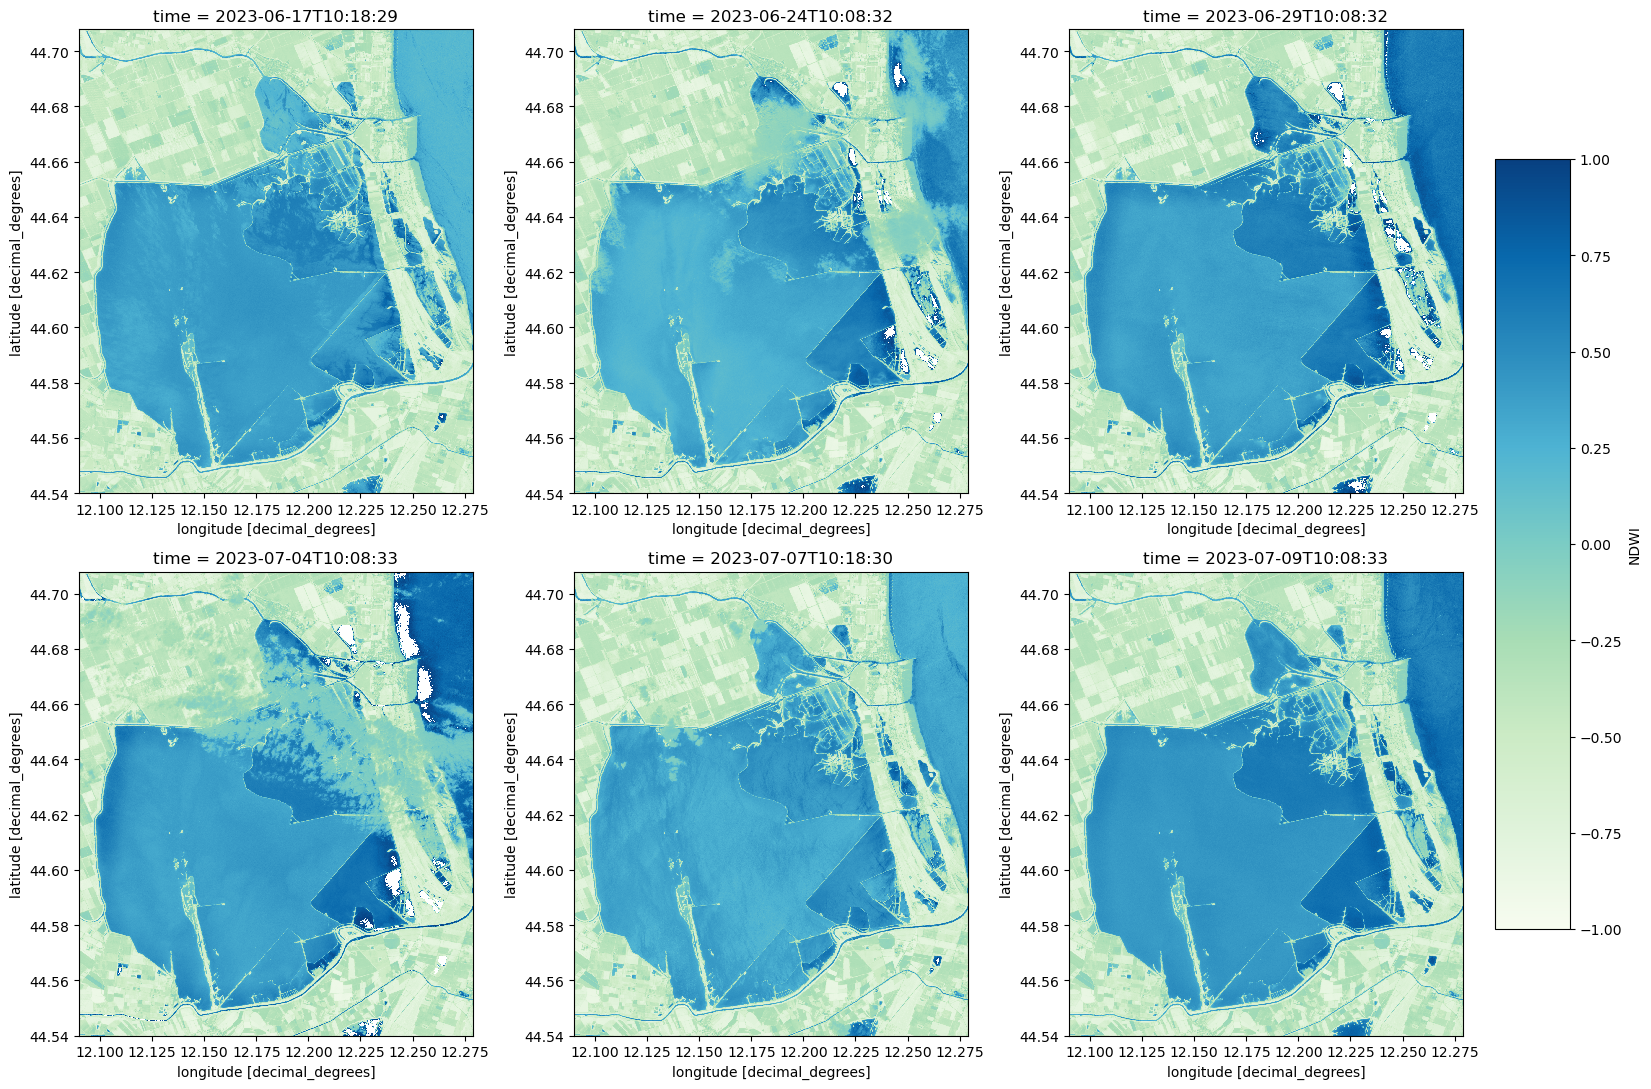

In [10]:
# Select timestamps
ndwi1 = s2_cube.NDWI.sel(time='2023-06-17 10:00:00', method='nearest')
ndwi2 = s2_cube.NDWI.sel(time='2023-06-24 10:00:00', method='nearest')
ndwi3 = s2_cube.NDWI.sel(time='2023-06-29 10:00:00', method='nearest')
ndwi4 = s2_cube.NDWI.sel(time='2023-07-04 10:00:00', method='nearest')
ndwi5 = s2_cube.NDWI.sel(time='2023-07-07 10:00:00', method='nearest')
ndwi6 = s2_cube.NDWI.sel(time='2023-07-09 10:00:00', method='nearest')


# Plot 
f = plt.figure(figsize=[15,11])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)
ax4 = f.add_subplot(2,3, 4)
ax5 = f.add_subplot(2,3, 5)
ax6 = f.add_subplot(2,3, 6)

axlist=[ax1,ax2,ax3,ax4,ax5,ax6]

t = ndwi1.plot.imshow(ax=ax1, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi2.plot.imshow(ax=ax2, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi3.plot.imshow(ax=ax3, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi4.plot.imshow(ax=ax4, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi5.plot.imshow(ax=ax5, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi6.plot.imshow(ax=ax6, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="NDWI")

#we will save the output image so we need to ensure that it is fully rendered 
plt.tight_layout() 

# Save the figure to a PNG file
plt.savefig('NDWI.png')

plt.show()

We could use the NDWI to estimate the surface water extent. The more images we have available, the more reliable the estimate can be. Examining the satellite images above we observe that not all of the images would be useful, as some of the lake area is covered with clouds. To overcome this limitation and have a denser time series we could rely on synthetic aperture radar observations, for example from the Copernicus Sentinel-1 platform. 

### Sentinel-1 description

Like Sentinel-2, Sentinel-1 is also part of the Copernicus programme and collects data globally with a revisit time of 5 days. In contrast to Sentinel-2, Sentinel-1 SAR is an active sensor using SAR signals recording the backscatter. Due to the wavelengths used, SAR is not hindered by clouds and can be operated day and night. 

### Check Sentinel-1 GRD available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset. 

In [11]:
# List bands for S1-GRD
SH.band_names('S1GRD')

['VV', 'HH', 'VH', 'localIncidenceAngle', 'scatteringArea', 'shadowMask', 'HV']

### Build an xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S1GRD` for Sentinel-1 GRD. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call just the VV polarisation band.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-1 GRD data is available from February 2015 onwards. In this example, we will fetch data for June 2023 - mid July 2023.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30m` corresponds to 30 minutes, thus avoiding duplicate datasets.

In [12]:
# Setup xcube
s1_cube_config = CubeConfig(dataset_name='S1GRD',
                         band_names=['VV'],
                         bbox=lake_bbox,
                         spatial_res=0.000089,
                         time_range=['2023-06-01', '2023-07-16'],
                         time_tolerance='30m')

### Open the xcube

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube.

In [13]:
# Open cube (on the fly)
s1_cube = open_cube(s1_cube_config, **sh_credentials)

# Display contents
s1_cube

/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/xcube_sh/sentinelhub.py:243: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(dt,
/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/xcube_sh/sentinelhub.py:243: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(dt,


<xarray.Dataset>
Dimensions:    (time: 11, lat: 1886, lon: 2122, bnds: 2)
Coordinates:
  * lat        (lat) float64 44.71 44.71 44.71 44.71 ... 44.54 44.54 44.54 44.54
  * lon        (lon) float64 12.09 12.09 12.09 12.09 ... 12.28 12.28 12.28 12.28
  * time       (time) datetime64[ns] 2023-06-03T05:19:46 ... 2023-07-10T17:06:57
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(11, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 943, 1061), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-07-16T01:25:41.443109
    time_coverage_start:     2023-06-03T05:19:46+00:00
    time_coverage_end:       2023-07-10T17:06:57+00:00
    time_coverage_duration:  P37DT11H47M11S
    geospatial_lon_min:      12.09
    geospatial_lat_min:      44.54
    geospatial_lon_max:      12.278858
    geospatial_lat_max:      44.707854
    processing_level:        L1B

### Visualising the water areas using SAR

We are going to use the VV band to visualise the flooding. From our earlier visualisation, we know that the area had some cloud coverage around the date 2023-07-04. We will search for Sentinel-1 acquisitions around that date in order to obtain a denser time series. 


Radar data has very large dynamic range a very imbalanced histogram (>95% of all values are smaller than 1, but the remaining 5 % can be impractically large). Thus, to obtain a visualisation with a better contrast in which the water bodies would be darker and the land pixels would be brighter, it is recommended to convert the data to log-scale. 
To convert the pixel values from Digital Number to decibels we can mutiply the log10 of each DN pixel by 10. Secondly, as there will be pixels with a value of -inf after this operation, we need to account for this with the second function which will automatically assign 0 to these pixels. 

In [14]:
# Convert VV Digital numbers to Decibels
vv_dn = s1_cube.VV
vv_db = 10 * (np.log10(vv_dn))

vv_db = vv_db.where(np.isfinite(vv_db), 0)

vv_db.attrs['long_name']='VV_dB'
vv_db.attrs['units']='decibels'

s1_cube['VV_dB']= vv_db

Like previously, we are going to visualise the `VV_dB` variable we have just generated for our AOI. 

/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


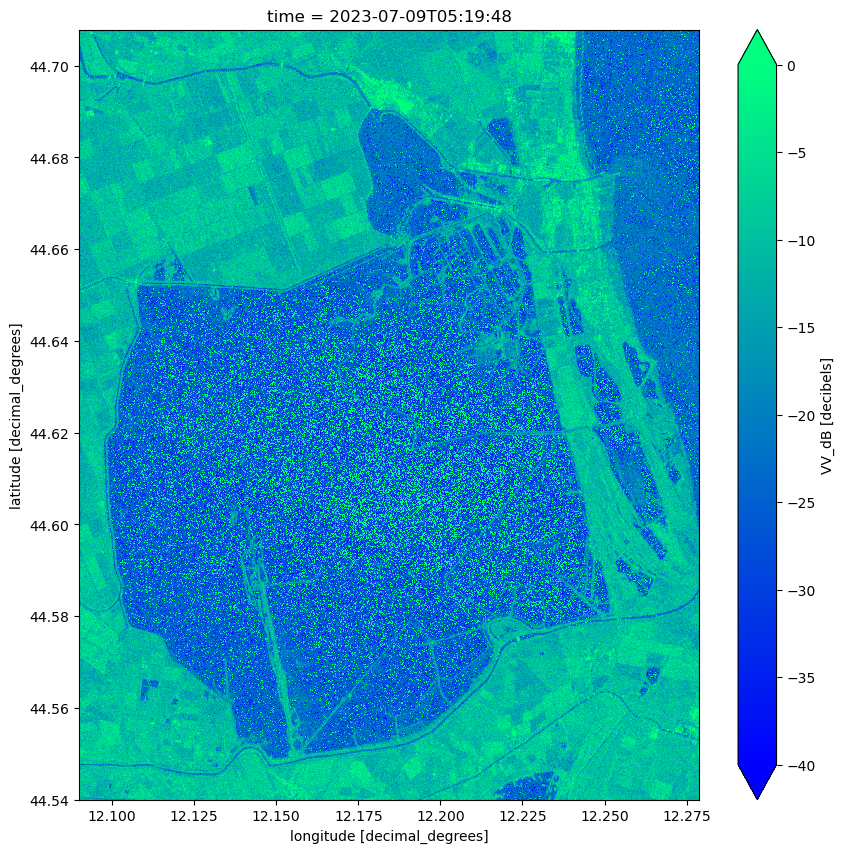

In [15]:
# select and define the timestamp you want to visualise 
VV_dB_timestamp = s1_cube.VV_dB.sel(time='2023-07-09 10:00:00', method='nearest')

# plot the timestamp
VV_dB_timestamp.plot.imshow(vmin=-40, vmax=0, cmap='winter', figsize=(10, 10))

# save and display the plot
plt.show()

This looks very similar to the NDWI we derived earlier showing the water extent fairly clearly (the blue areas). Let's visualise it over several timestamps to confirm that this is a good variable to use to generate a lake mask. 

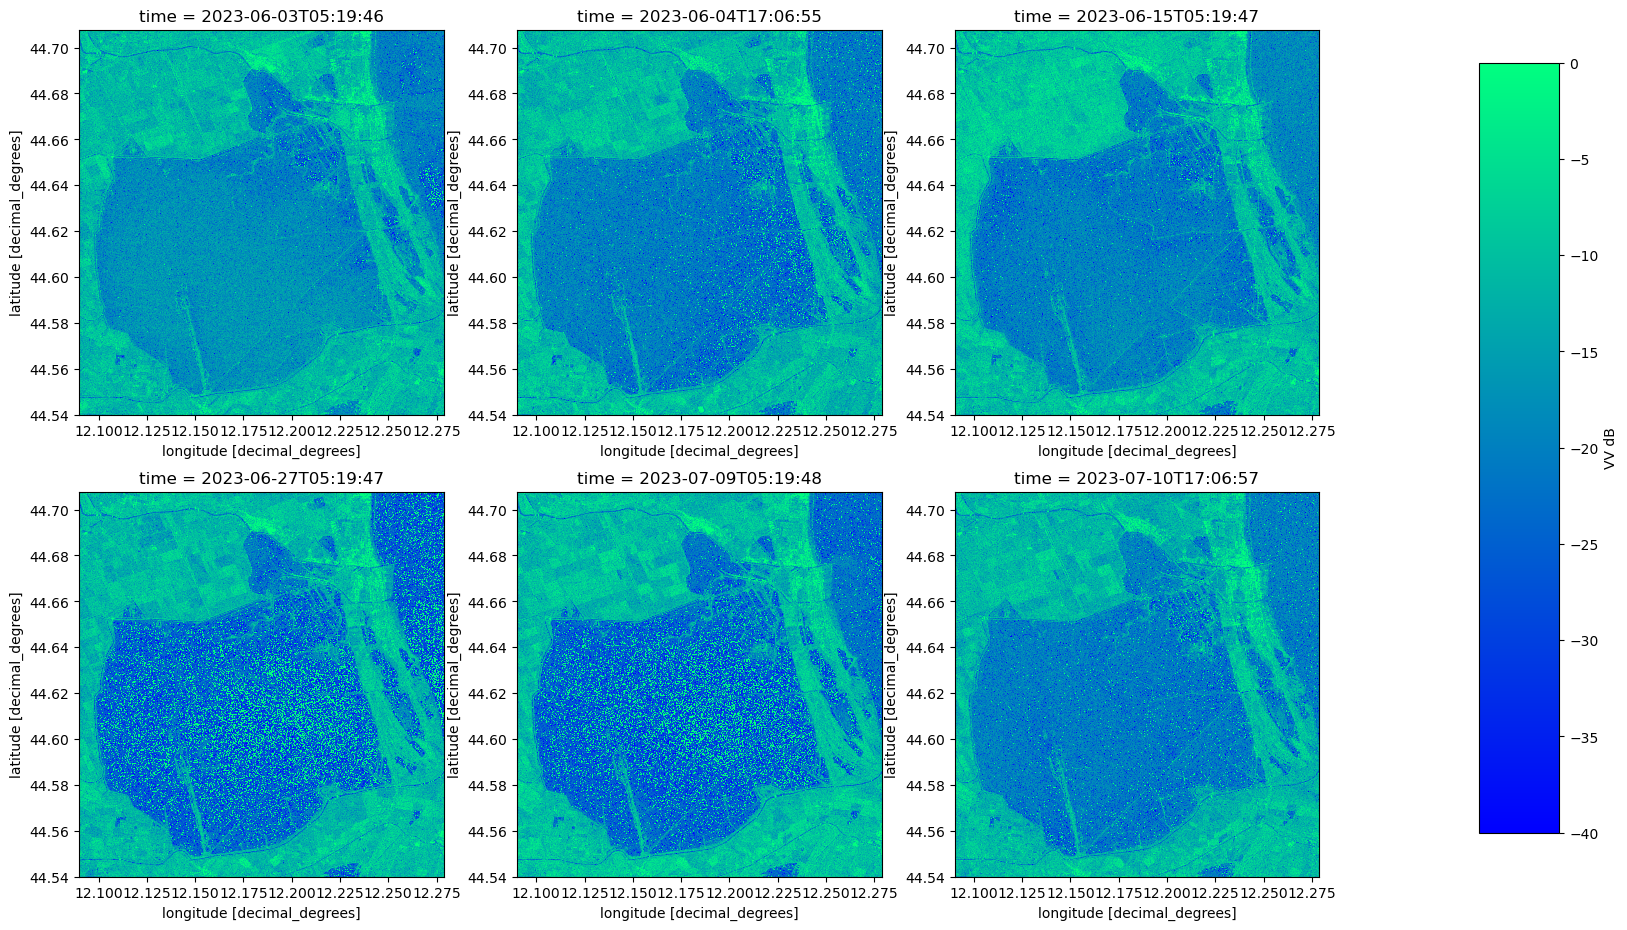

In [16]:
#### Timestamp selection
vv1 = s1_cube.VV_dB.sel(time='2023-06-03 10:00:00', method='nearest')
vv2 = s1_cube.VV_dB.sel(time='2023-06-04 10:00:00', method='nearest')
vv3 = s1_cube.VV_dB.sel(time='2023-06-15 10:00:00', method='nearest')
vv4 = s1_cube.VV_dB.sel(time='2023-06-27 10:00:00', method='nearest')
vv5 = s1_cube.VV_dB.sel(time='2023-07-09 10:00:00', method='nearest')
vv6 = s1_cube.VV_dB.sel(time='2023-07-10 10:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[16,11])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)
ax4 = f.add_subplot(2,3, 4)
ax5 = f.add_subplot(2,3, 5)
ax6 = f.add_subplot(2,3, 6)

axlist=[ax1,ax2,ax3,ax4,ax5,ax6]

t = vv1.plot.imshow(ax=ax1, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv2.plot.imshow(ax=ax2, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv3.plot.imshow(ax=ax3, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv4.plot.imshow(ax=ax4, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv5.plot.imshow(ax=ax5, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv6.plot.imshow(ax=ax6, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="VV dB")

plt.show()

Depending on the local conditions (e.g. terrain orientation, slope) and weather conditions, optical or radar imagery may be more useful. In this case both types of observations seem to provide a good view of the water surface area extent. 

Next we will generate a flood mask using a threshold. 
- for SAR images, generally, as a good rule of thumb, in the VV band, values below -20 dB are usually surface water. We will try this value first, but we will also look to visualise how the flood mask changes if we adjust the threshold value. 
- observing the NDWI range of values, we can chose values above 0.25 to correspond to the water class. 

First, let's generate the new variable using the `.where` function in xarray.

At first glance, the below cell may not make much sense. It may read that the step 1 function as assigning a value of 1 to pixels in VV_dB that are equal or more than -20. However, what is actually happening is that the `.where` function preserves all the pixel values in the variable that are below -20 and assigns everything else a value of 1. More can be found in the xarray documentation http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html 

In [17]:
# mask the Sentinel-1 data

# Assign all pixels equal or smaller than -20 a value of 1 and preserve the values of all other pixels 
step1 = s1_cube.VV_dB.where(s1_cube.VV_dB > -20, 1)

# Assign all other pixels a value of 0. 
water = step1.where(step1 == 1, 0)

water.attrs['long_name'] ='water'
water.attrs['units'] ='nounits'

s1_cube['water'] = water

Next let's see what happens to the mask extent if we change the threshold to -15 dB and -25dB:

In [18]:
# Sentinel-1
water_threshold1_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB > -15, 1)
water_threshold2_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB > -20, 1)
water_threshold3_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB > -25, 1)

water_threshold1_step2 = water_threshold1_step1.where(water_threshold1_step1 == 1, 0)
water_threshold2_step2 = water_threshold2_step1.where(water_threshold2_step1 == 1, 0)
water_threshold3_step2 = water_threshold3_step1.where(water_threshold3_step1 == 1, 0)

water_threshold1 = water_threshold1_step2.sel(time='2023-06-15 10:00:00', method='nearest')
water_threshold2 = water_threshold2_step2.sel(time='2023-06-15 10:00:00', method='nearest')
water_threshold3 = water_threshold3_step2.sel(time='2023-06-15 10:00:00', method='nearest')

Next we will plot the new thresholds we want to test:

/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


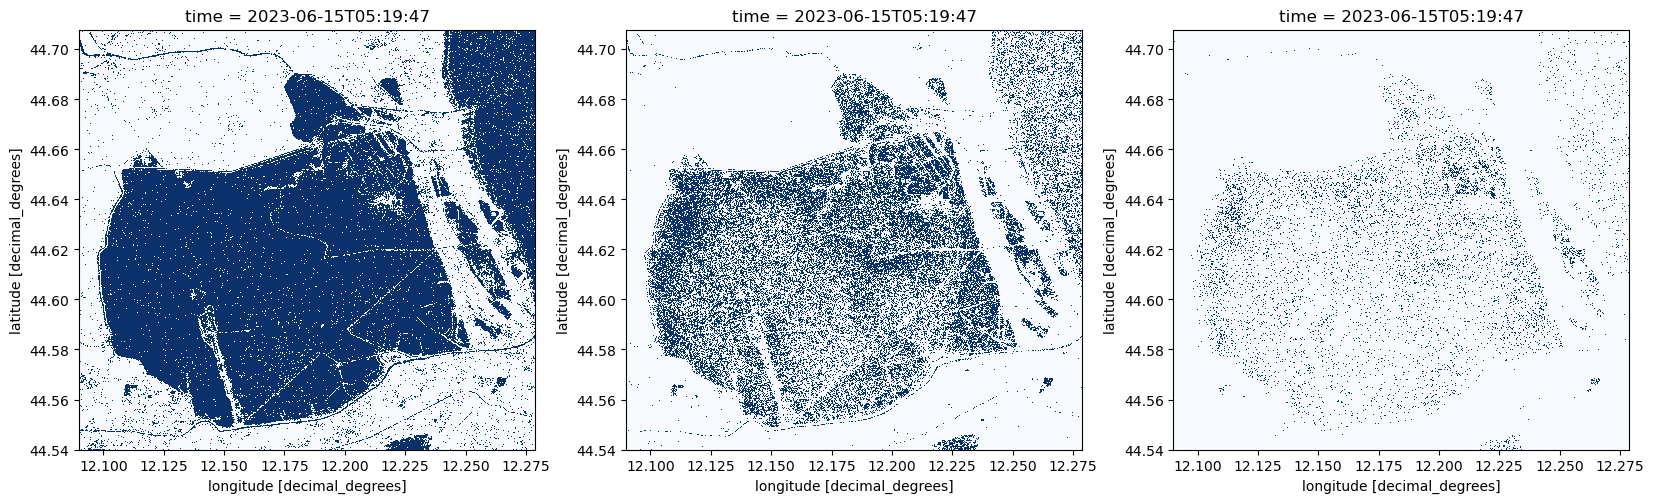

In [19]:
# Plot 
f = plt.figure(figsize=[20,12])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)

water_threshold1.plot.imshow(ax=ax1, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
water_threshold2.plot.imshow(ax=ax2, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
water_threshold3.plot.imshow(ax=ax3, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)

plt.show()

In [20]:
# mask the Sentinel-2 data

# Assign all pixels equal or larger than 0.25 a value of 1 and preserve the values of pixels 
step11 = ndwi1.where(ndwi1 < 0.25, 1)

# Assign all other pixels a value of 0. 
water1 = step1.where(step1 == 1, 0)

water1.attrs['long_name'] ='water'
water1.attrs['units'] ='nounits'

s2_cube['water'] = water1

In [21]:
# Sentinel-2
water_threshold1_step11 = ndwi1.where(ndwi1 < 0.15, 1)
water_threshold2_step11 = ndwi1.where(ndwi1 < 0.25, 1)
water_threshold3_step11 = ndwi1.where(ndwi1 < 0.30, 1)

water_threshold1_step21 = water_threshold1_step11.where(water_threshold1_step11 == 1, 0)
water_threshold2_step21 = water_threshold2_step11.where(water_threshold2_step11 == 1, 0)
water_threshold3_step21 = water_threshold3_step11.where(water_threshold3_step11 == 1, 0)

water_threshold11 = water_threshold1_step21
water_threshold21 = water_threshold2_step21
water_threshold31 = water_threshold3_step21

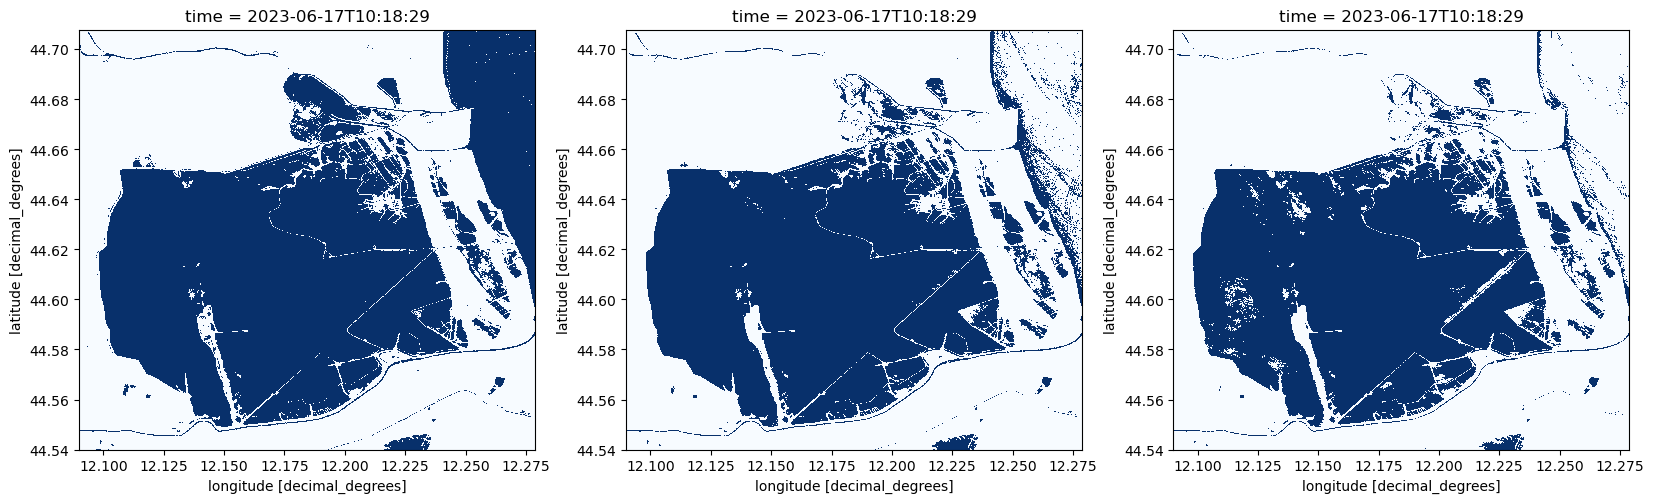

In [22]:
# Plot 
f = plt.figure(figsize=[20,12])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)

water_threshold11.plot.imshow(ax=ax1, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
water_threshold21.plot.imshow(ax=ax2, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
water_threshold31.plot.imshow(ax=ax3, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)

plt.show()

Observe the differences in the water mask due to the threshold.

### Estimating the surface water area extent


Let's estimate the area covered by water during the time period we are examining. 

We can also estimate which is the area that is most covered by water by dividing the sum of the water pixels by the number of timesteps in the data cube (the count). 

In [23]:
# previously we only kept 1 time step when we selected ndwi1
# now we want to keep the full datacube in order to average in time

# Assign all pixels equal or larger than 0.25 a value of 1 and preserve the values of all other pixels 
step1 = s2_cube.NDWI.where(s2_cube.NDWI < 0.25, 1)

# Assign all other pixels a value of 0. 
water = step1.where(step1 == 1, 0)

water.attrs['long_name'] ='water'
water.attrs['units'] ='nounits'

s2_cube['water'] = water


water_sum = s2_cube.NDWI.sum(dim="time")
water_count = s2_cube.NDWI.count(dim="time")
water_average = water_sum / water_count


water_average.attrs['long_name']='water area'
water_average.attrs['units']='nounits'

ndwi['water_average']= water_average

Now let's plot the water_average into a plot:

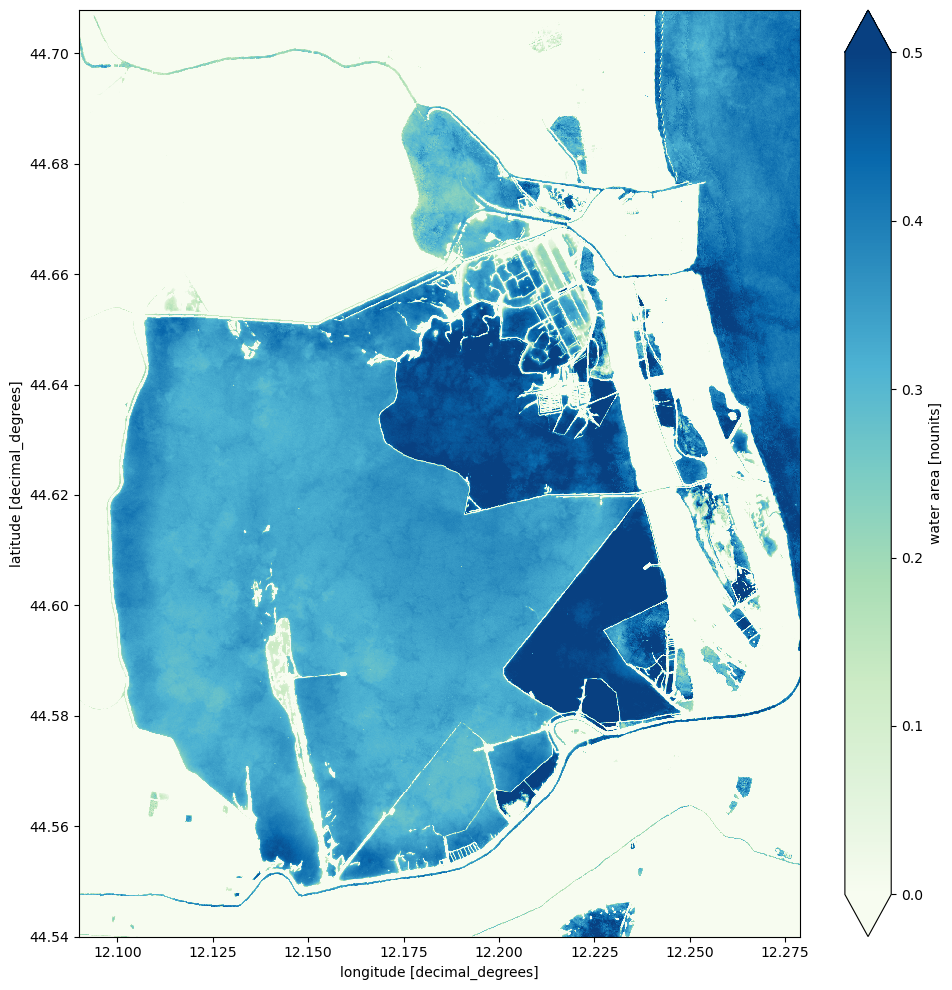

In [24]:
water_average.plot.imshow(cmap='GnBu', vmin=0, vmax=0.5, figsize=(10, 10))

plt.tight_layout()

#expport to png
plt.savefig('figure.png')

plt.show()

This looks great, we have identified the lake area very clearly here and can also observe how the lake may change in size over time. 

## Access environmental variables and other datasets

This [Notebook](https://nbviewer.hub.eox.at/notebooks/eurodatacube/notebooks/curated/EDC_xcube_generator_service.ipynb) demonstrates how to:

request data from selected Copernicus Services,
request data from Copernicus Climate Data Store,
request data from ESA Climate Change Initiative.